# Example Notebook : Weibull
In this notebook, we'll use the **mastectomy dataset**, which contains information about breast cancer patients and their survival times. We will use the **Bayesian Weibull Model** (implemented in `PyBH`) to analyze survival data and compare patients with and without metastasis.

In [11]:
import sys
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Add parent directory to path to import pymc_models

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../..')))

from PyBH.SurvivalAnalysis.pymc_models import Weibull
from PyBH.SurvivalAnalysis.SurvivalAnalysis import SurvivalAnalysis

## 1. Load Data

We load the `mastectomy` dataset using PyMC's data utility.

In [12]:
try:
    # Try loading via pymc
    data = pd.read_csv(pm.get_data("mastectomy.csv"))
except:
    # Fallback to hardcoded url or local file if pm.get_data fails (for offline safety)
    print("Could not load via pm.get_data, checking local or alternative source...")
    # Assuming it works as per user request, otherwise we might need a backup source
    # data = pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/mastectomy.csv")
    raise

print(f"Dataset loaded! Shape: {data.shape}")
print(data.head())

Dataset loaded! Shape: (44, 3)
   time  event metastasized
0    23   True           no
1    47   True           no
2    69   True           no
3    70  False           no
4   100  False           no


In [13]:
wbll = Weibull()

# Use PyBH's SurvivalAnalysis class to fit the model
# This automatically handles validation and preprocessing
survival_analysis = SurvivalAnalysis(
    model=wbll,
    data=data,
    time_col='time',
    event_col='event',
    draws=1000, tune=1000, chains=2
)

Initializing NUTS using jitter+adapt_diag...


   -> Mode: Bayesian (PyMC)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 2. Preprocessing

The dataset has:
- `time`: survival time
- `event`: 1 if event observed (death), 0 if censored
- `metastasized`: 'yes' or 'no'

In [5]:
# Ensure event column is numeric
data['event'] = data['event'].astype(int)
print(data['metastasized'].value_counts())

metastasized
yes    32
no     12
Name: count, dtype: int64


## 3. Fit Weibull Model (All Patients)

First, we fit the model on the entire population to get a global survival curve.

In [6]:
# Summary of the global model
survival_analysis.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.884,0.153,0.573,1.159,0.004,0.004,1156.0,959.0,1.0
beta,192.051,54.335,115.229,298.528,1.708,2.451,1343.0,974.0,1.0


<Axes: xlabel='Time', ylabel='Survival Probability'>

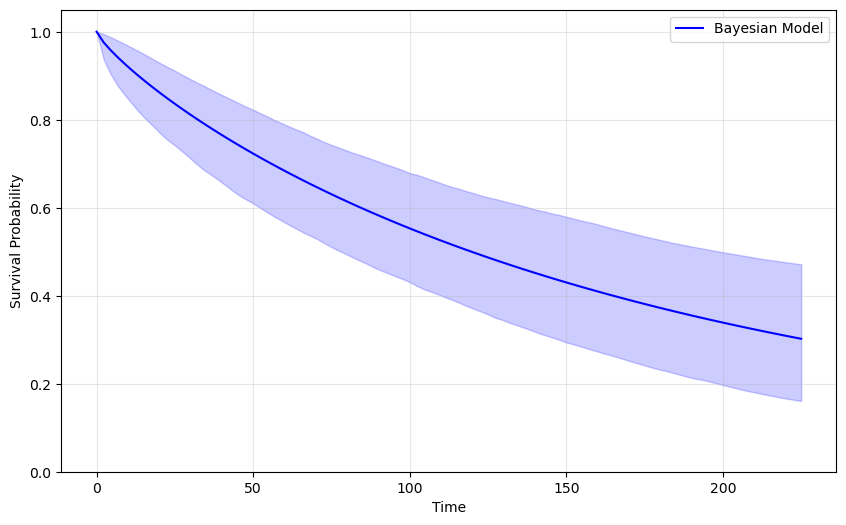

In [7]:
survival_analysis.plot_survival_function()

## 4. Compare Groups: Metastasis vs No Metastasis

We fit two separate models to see the impact of metastasis on survival.

In [8]:
data_yes = data[data['metastasized'] == 'yes']
data_no = data[data['metastasized'] == 'no']

print(f"N (Metastasized): {len(data_yes)}")
print(f"N (No Metastasis): {len(data_no)}")

wbll_yes = Weibull()
print("\nFitting Model: Metastasis = YES")
sa_yes = SurvivalAnalysis(model=wbll_yes, data=data_yes, time_col='time', event_col='event', draws=1000, tune=1000, chains=2, progressbar=False)

wbll_no = Weibull()
print("\nFitting Model: Metastasis = NO")
sa_no = SurvivalAnalysis(model=wbll_no, data=data_no, time_col='time', event_col='event', draws=1000, tune=1000, chains=2, progressbar=False)

Initializing NUTS using jitter+adapt_diag...


N (Metastasized): 32
N (No Metastasis): 12

Fitting Model: Metastasis = YES
   -> Mode: Bayesian (PyMC)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...



Fitting Model: Metastasis = NO
   -> Mode: Bayesian (PyMC)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### Compare Posteriors
Let's look at the posterior distributions for Mean Survival Time or just the parameters.

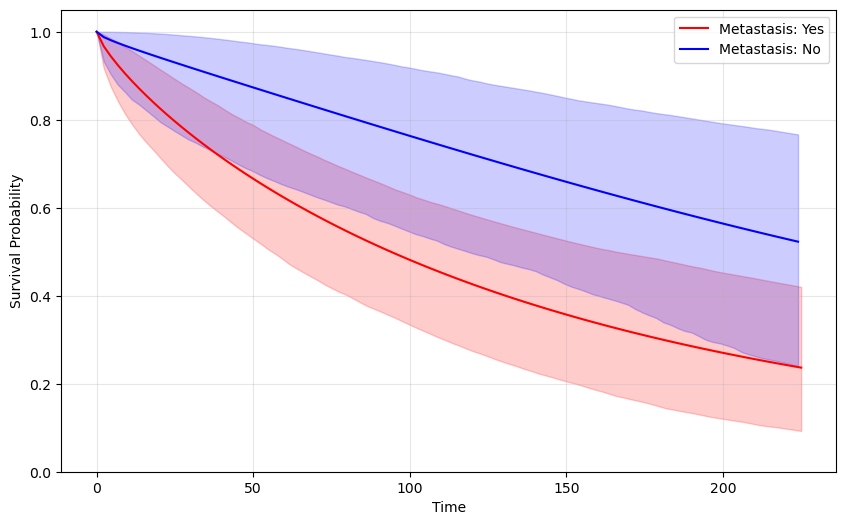

In [9]:
limit = data['time'].max()
times = np.linspace(0, limit, 100)

fig, ax = plt.subplots(figsize=(10, 6))
surv_yes = sa_yes.plot_survival_function(ax, label='Metastasis: Yes', color="red")
surv_no = sa_no.plot_survival_function(ax, label='Metastasis: No', color="Blue");

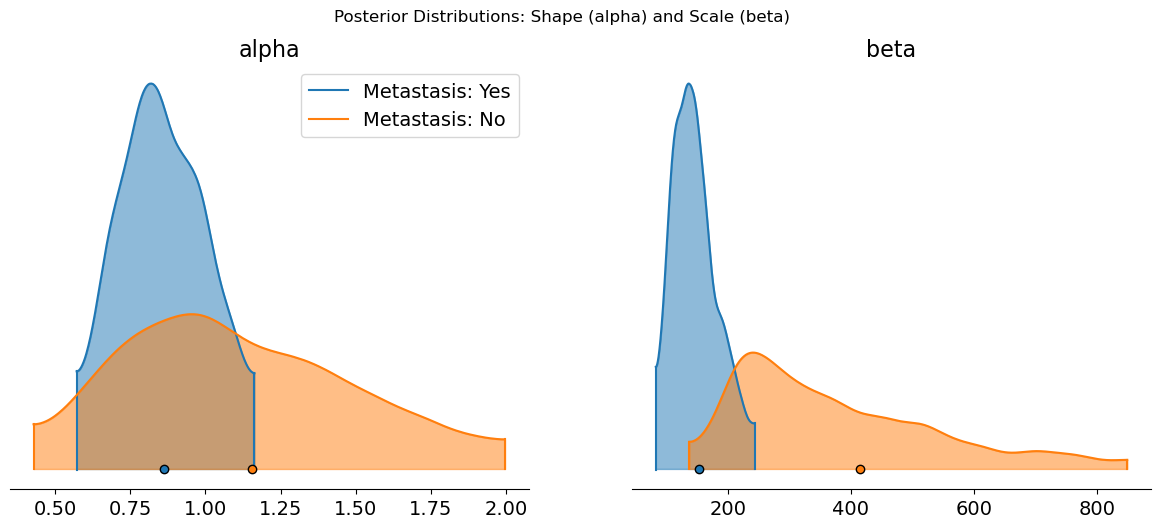

In [10]:
import arviz as az
import matplotlib.pyplot as plt
# Compare posteriors for Alpha (Shape) and Beta (Scale)
# We pass a list of InferenceData objects and their labels
az.plot_density(
    [sa_yes.idata, sa_no.idata], 
    var_names=["alpha", "beta"], 
    data_labels=["Metastasis: Yes", "Metastasis: No"],
    shade=0.5
)
plt.suptitle("Posterior Distributions: Shape (alpha) and Scale (beta)")
plt.show()